# In this notebook, we analyze $D$ matrices other than `D_trips.txt`

In [1]:
import csv
import numpy as np
from scipy.signal import periodogram, welch, savgol_filter
import matplotlib.pyplot as plt
import seaborn as sns

## 0. `D_trips`

In [2]:
D_trips = np.loadtxt('D_trips.txt')

In [3]:
D_trips2 = np.nan_to_num(D_trips)
D2 = np.nanmean(D_trips, axis=1)
f, Pxx = periodogram(D2, 24, scaling='spectrum')

Which frequencies are we interested in?
- 1 day = 24 hrs = 1/24 Hz = 0.0416 Hz = Index 366
- 35 days = 24x35 hrs = 1/(24x35) Hz = 0.00119 Hz = Index 16

In [31]:
def plot_periodogram(matrix, name, ymax):
    # Setting up the figure
    sns.set_style("white")
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    plt.figure(figsize = (10,4), dpi=200)

    matrix = np.nan_to_num(matrix)
    vector = np.nanmean(matrix, axis=1)
    f, Pxx = periodogram(vector, 24, scaling='spectrum')  # Need to sample only in 24 hr windows.
    x = 1/f[16:366]
    y = Pxx[16:366]
    plt.plot(x, y, '-')
    plt.xlim(1.5, 15)
    plt.xticks(range(2, 15, 1))
    plt.ylim(0, ymax)
    plt.xlabel('Period (in days)')
    plt.ylabel('Power spectrum (in V$^2$)')
    plt.title(f'Power spectrum periodogram of {name}\n averaged over all links')
    #plt.legend()
    plt.tight_layout()
    sns.despine()

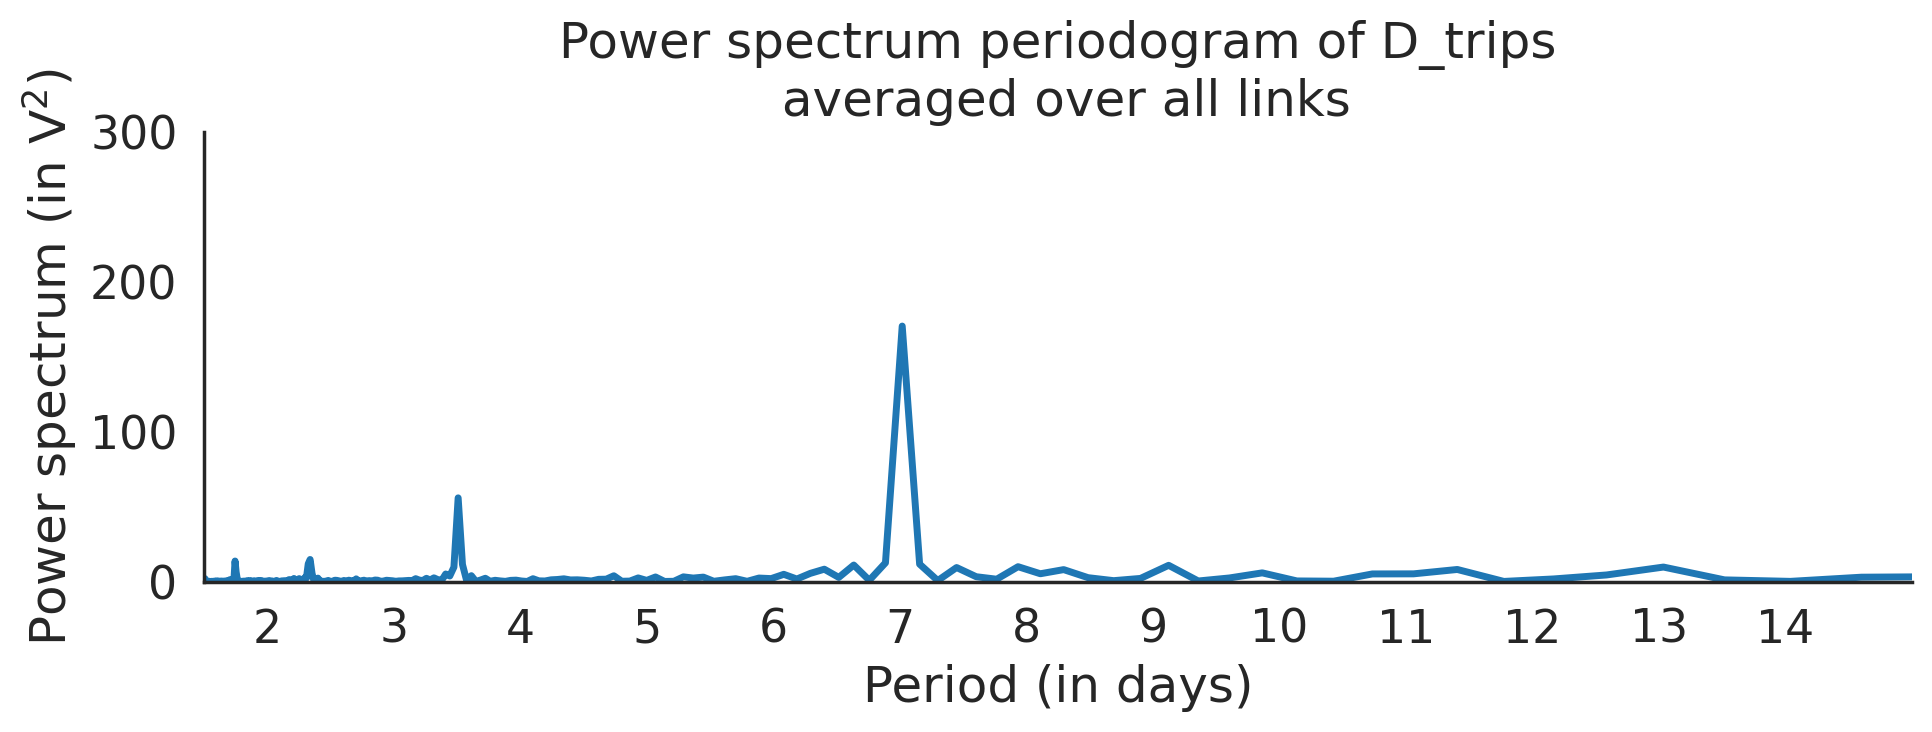

In [32]:
plot_periodogram(D_trips, 'D_trips', ymax=3e2)
plt.savefig('D_trips_periodogram')

## 1. `D_traveltimes`

In [8]:
D_traveltimes = np.loadtxt('D_traveltimes.txt')
print(D_traveltimes.shape)

(8760, 2302)


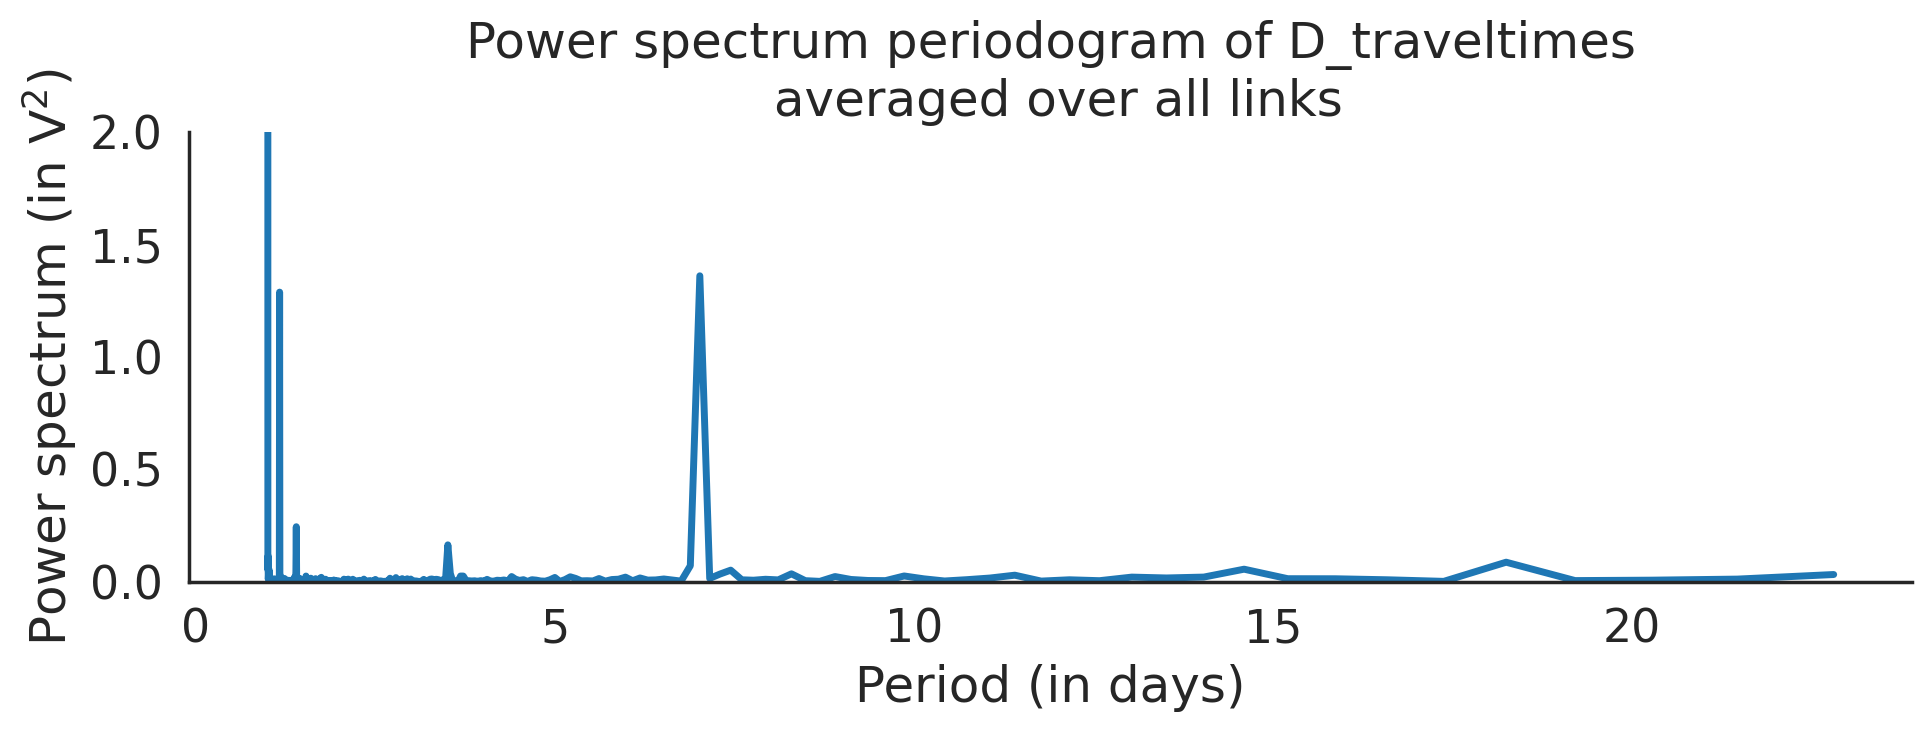

In [9]:
plot_periodogram(D_traveltimes, 'D_traveltimes', ymax=2)

## 2. `D_pace`

We start by creating a dictionary that pairs `link_id` with `street_length` for every link in the database.

In [10]:
with open('../DataFiles/links.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    header, *data = list(reader)
    
    street_length_index = header.index('street_length')
    street_lenghts = {row[0] : float(row[street_length_index]) for row in data}
    print(len(street_lenghts))

260855


Next, we create an array of street lenghts corresponding only to full links.

In [11]:
with open('../DataFiles/full_link_ids.txt') as readfile:
    full_link_ids = readfile.readlines()
    full_link_ids = [i.strip() for i in full_link_ids]

full_link_street_lengths = np.array([street_lenghts[link_id] for link_id in full_link_ids])

We now perform a column-wise division of `D_traveltimes` with `full_link_street_lengths`.

In [12]:
D_pace = D_traveltimes / full_link_street_lengths
D_pace.shape

(8760, 2302)

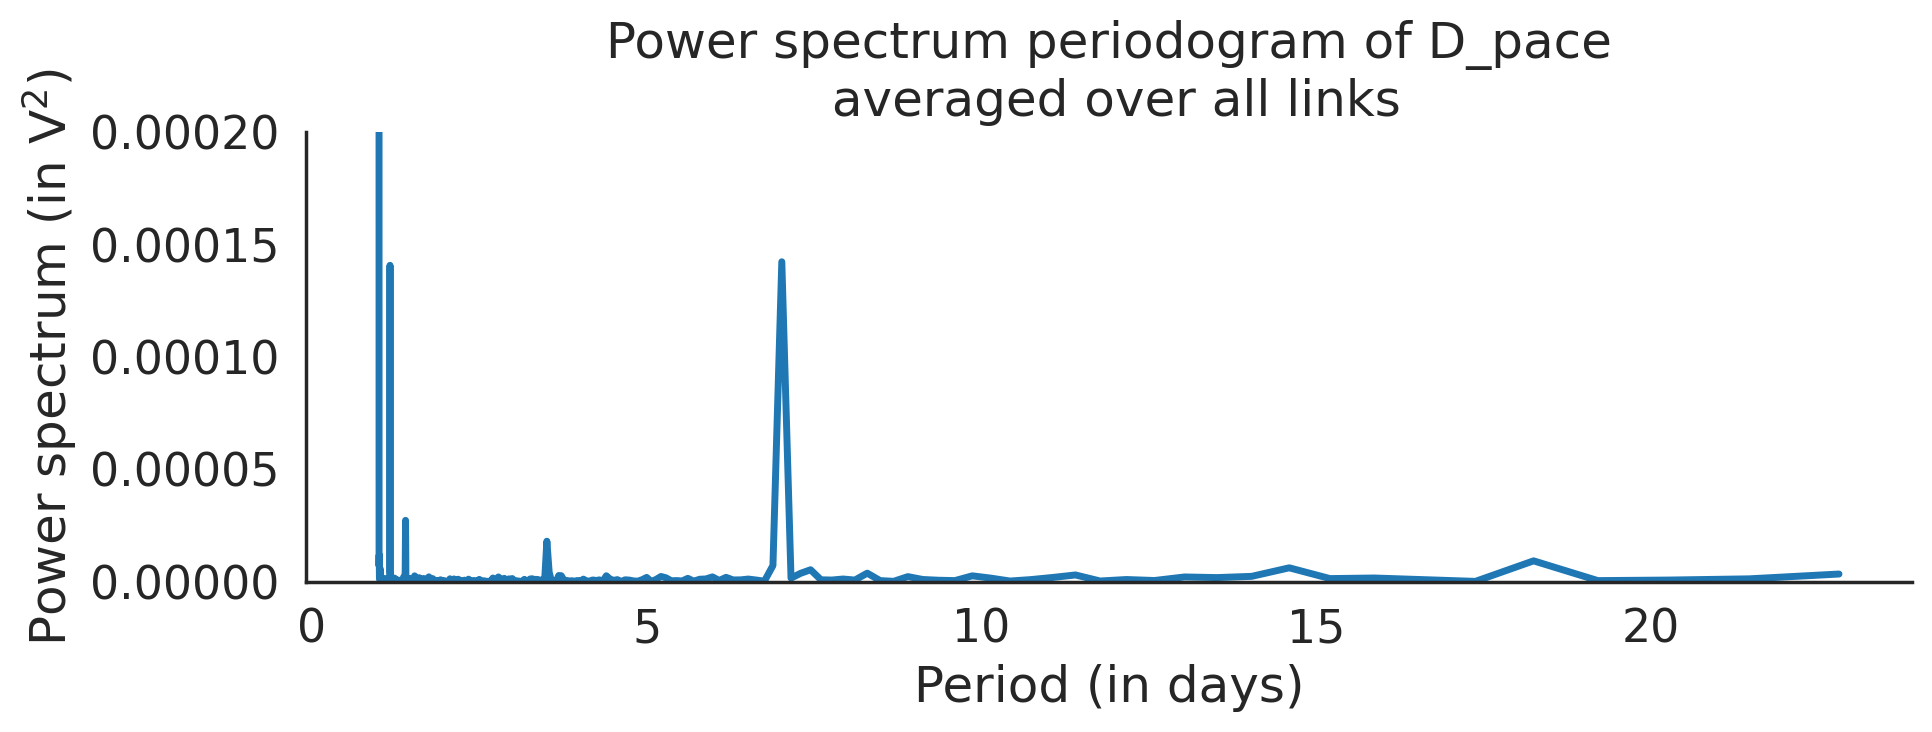

In [13]:
plot_periodogram(D_pace, 'D_pace', ymax=2e-4)

## 3. `D_speed`

Next, we invert each entry in `D_pace` to obtain `D_speed`.

In [14]:
D_speed = 1./D_pace
D_speed.shape

(8760, 2302)

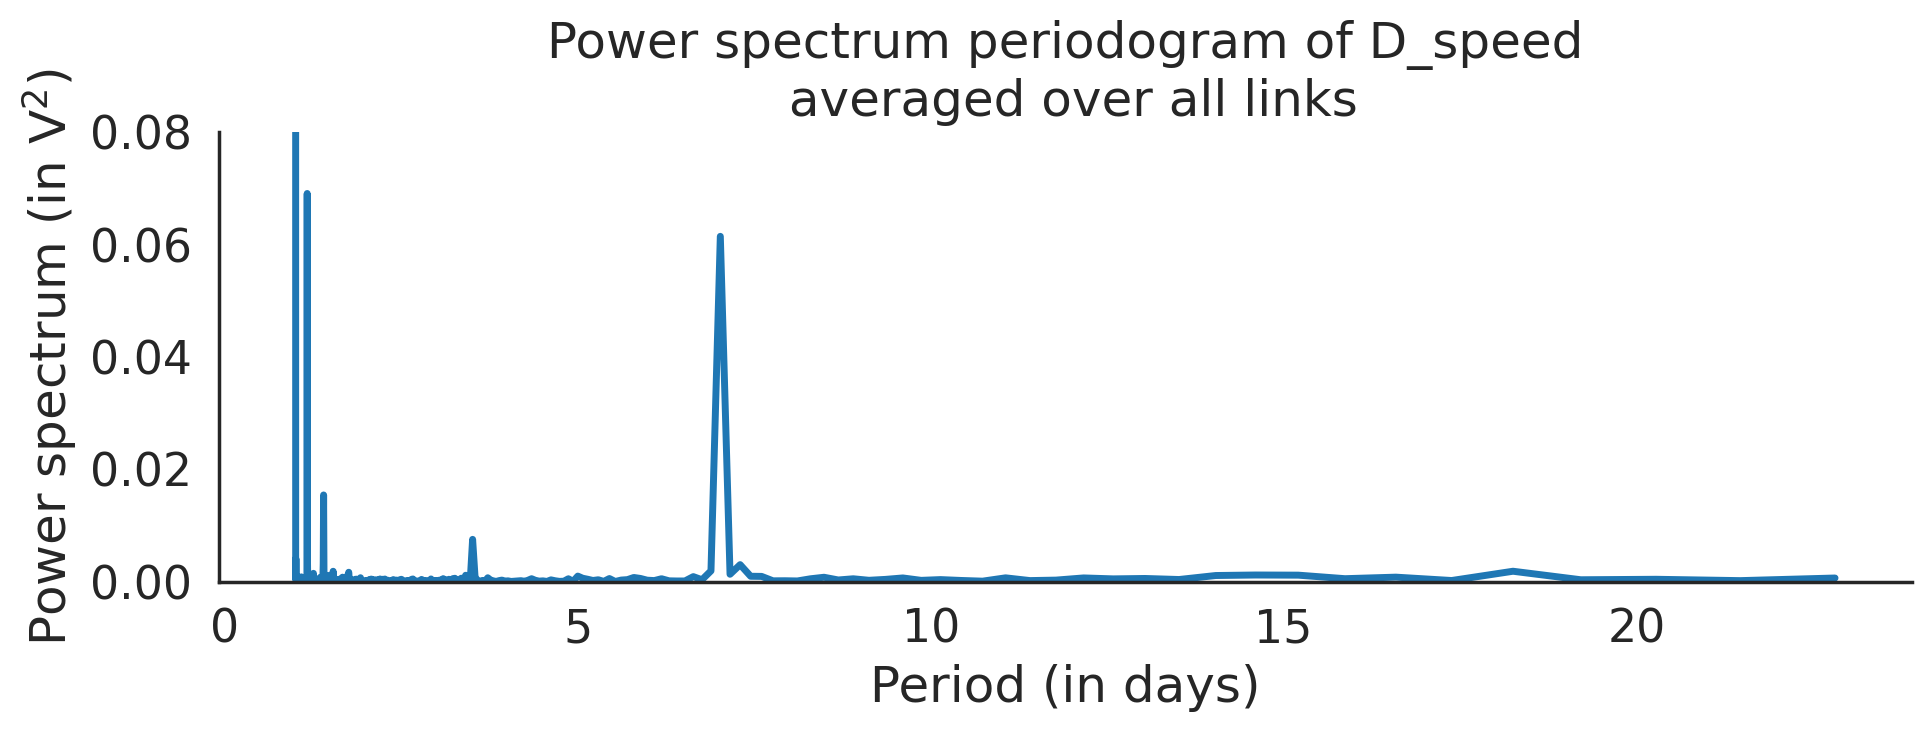

In [15]:
plot_periodogram(D_speed, 'D_speed', ymax=0.08)

## 4. D_density

We compute `D_density` as the column-ratio of `D_trips` with `full_link_street_lengths`.

In [16]:
D_density = D_trips / full_link_street_lengths
D_density.shape

(8760, 2302)

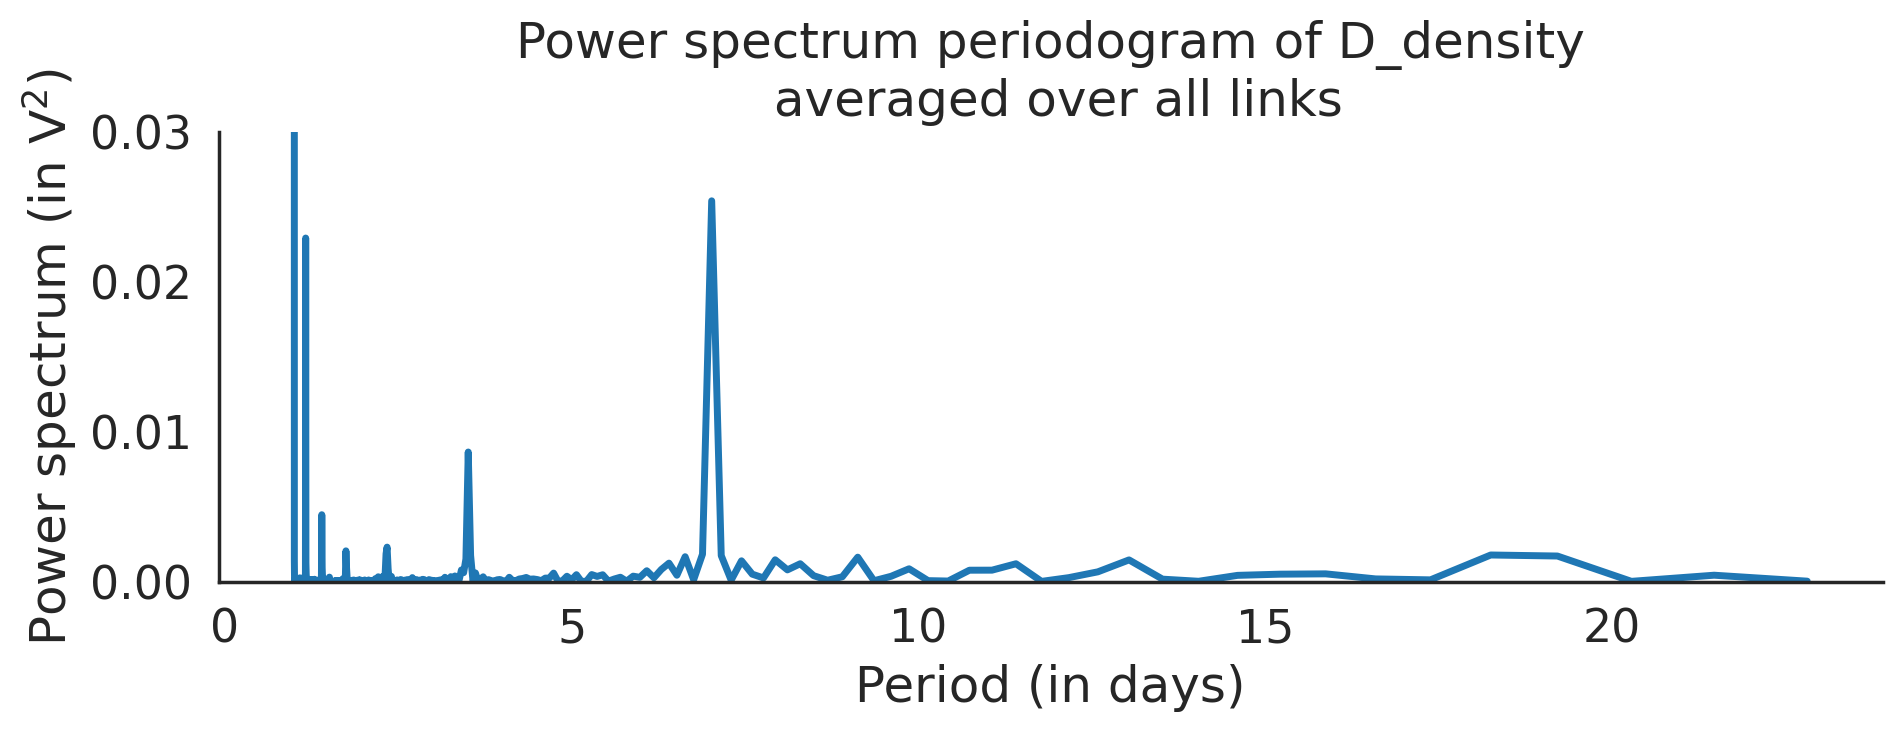

In [17]:
plot_periodogram(D_density, 'D_density', ymax=0.03)

## Combining all the graphs into one.

First we add an "axis" argument to the plotting function.

In [18]:
def plot_periodogram(matrix, name, ymax, axis):
    matrix = np.nan_to_num(matrix)
    vector = np.nanmean(matrix, axis=1)
    f, Pxx = periodogram(vector, 24, scaling='spectrum')  # Need to sample only in 24 hr windows.
    x = 1/f[16:366]
    y = Pxx[16:366]
    axis.plot(x, y, '-')
    axis.set(ylim=(0, ymax))
    #axis.set(xlabel = 'Period (in days)')
    #axis.set(ylabel = 'Power spectrum (in V$^2$)')
    #axis.set(title = f'D = {name}')
    sns.despine()

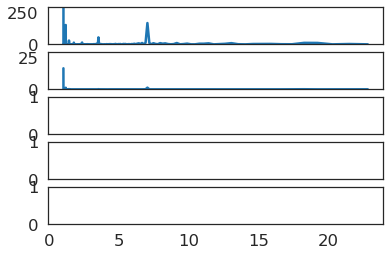

<Figure size 2000x800 with 0 Axes>

In [19]:
# Setting up the figure
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
fig, axs = plt.subplots(5, sharex=True)
fig = plt.figure(figsize = (10,4), dpi=200)
fig.suptitle('Power spectrum periodogram of D\n averaged over all links')
plot_periodogram(D_trips, 'D_trips', ymax=3e2, axis=axs[0])
plot_periodogram(D_traveltimes, 'D_traveltimes', ymax=30, axis=axs[1])
plt.show()

In [20]:
A = axs[0]

In [21]:
A.set()

[]

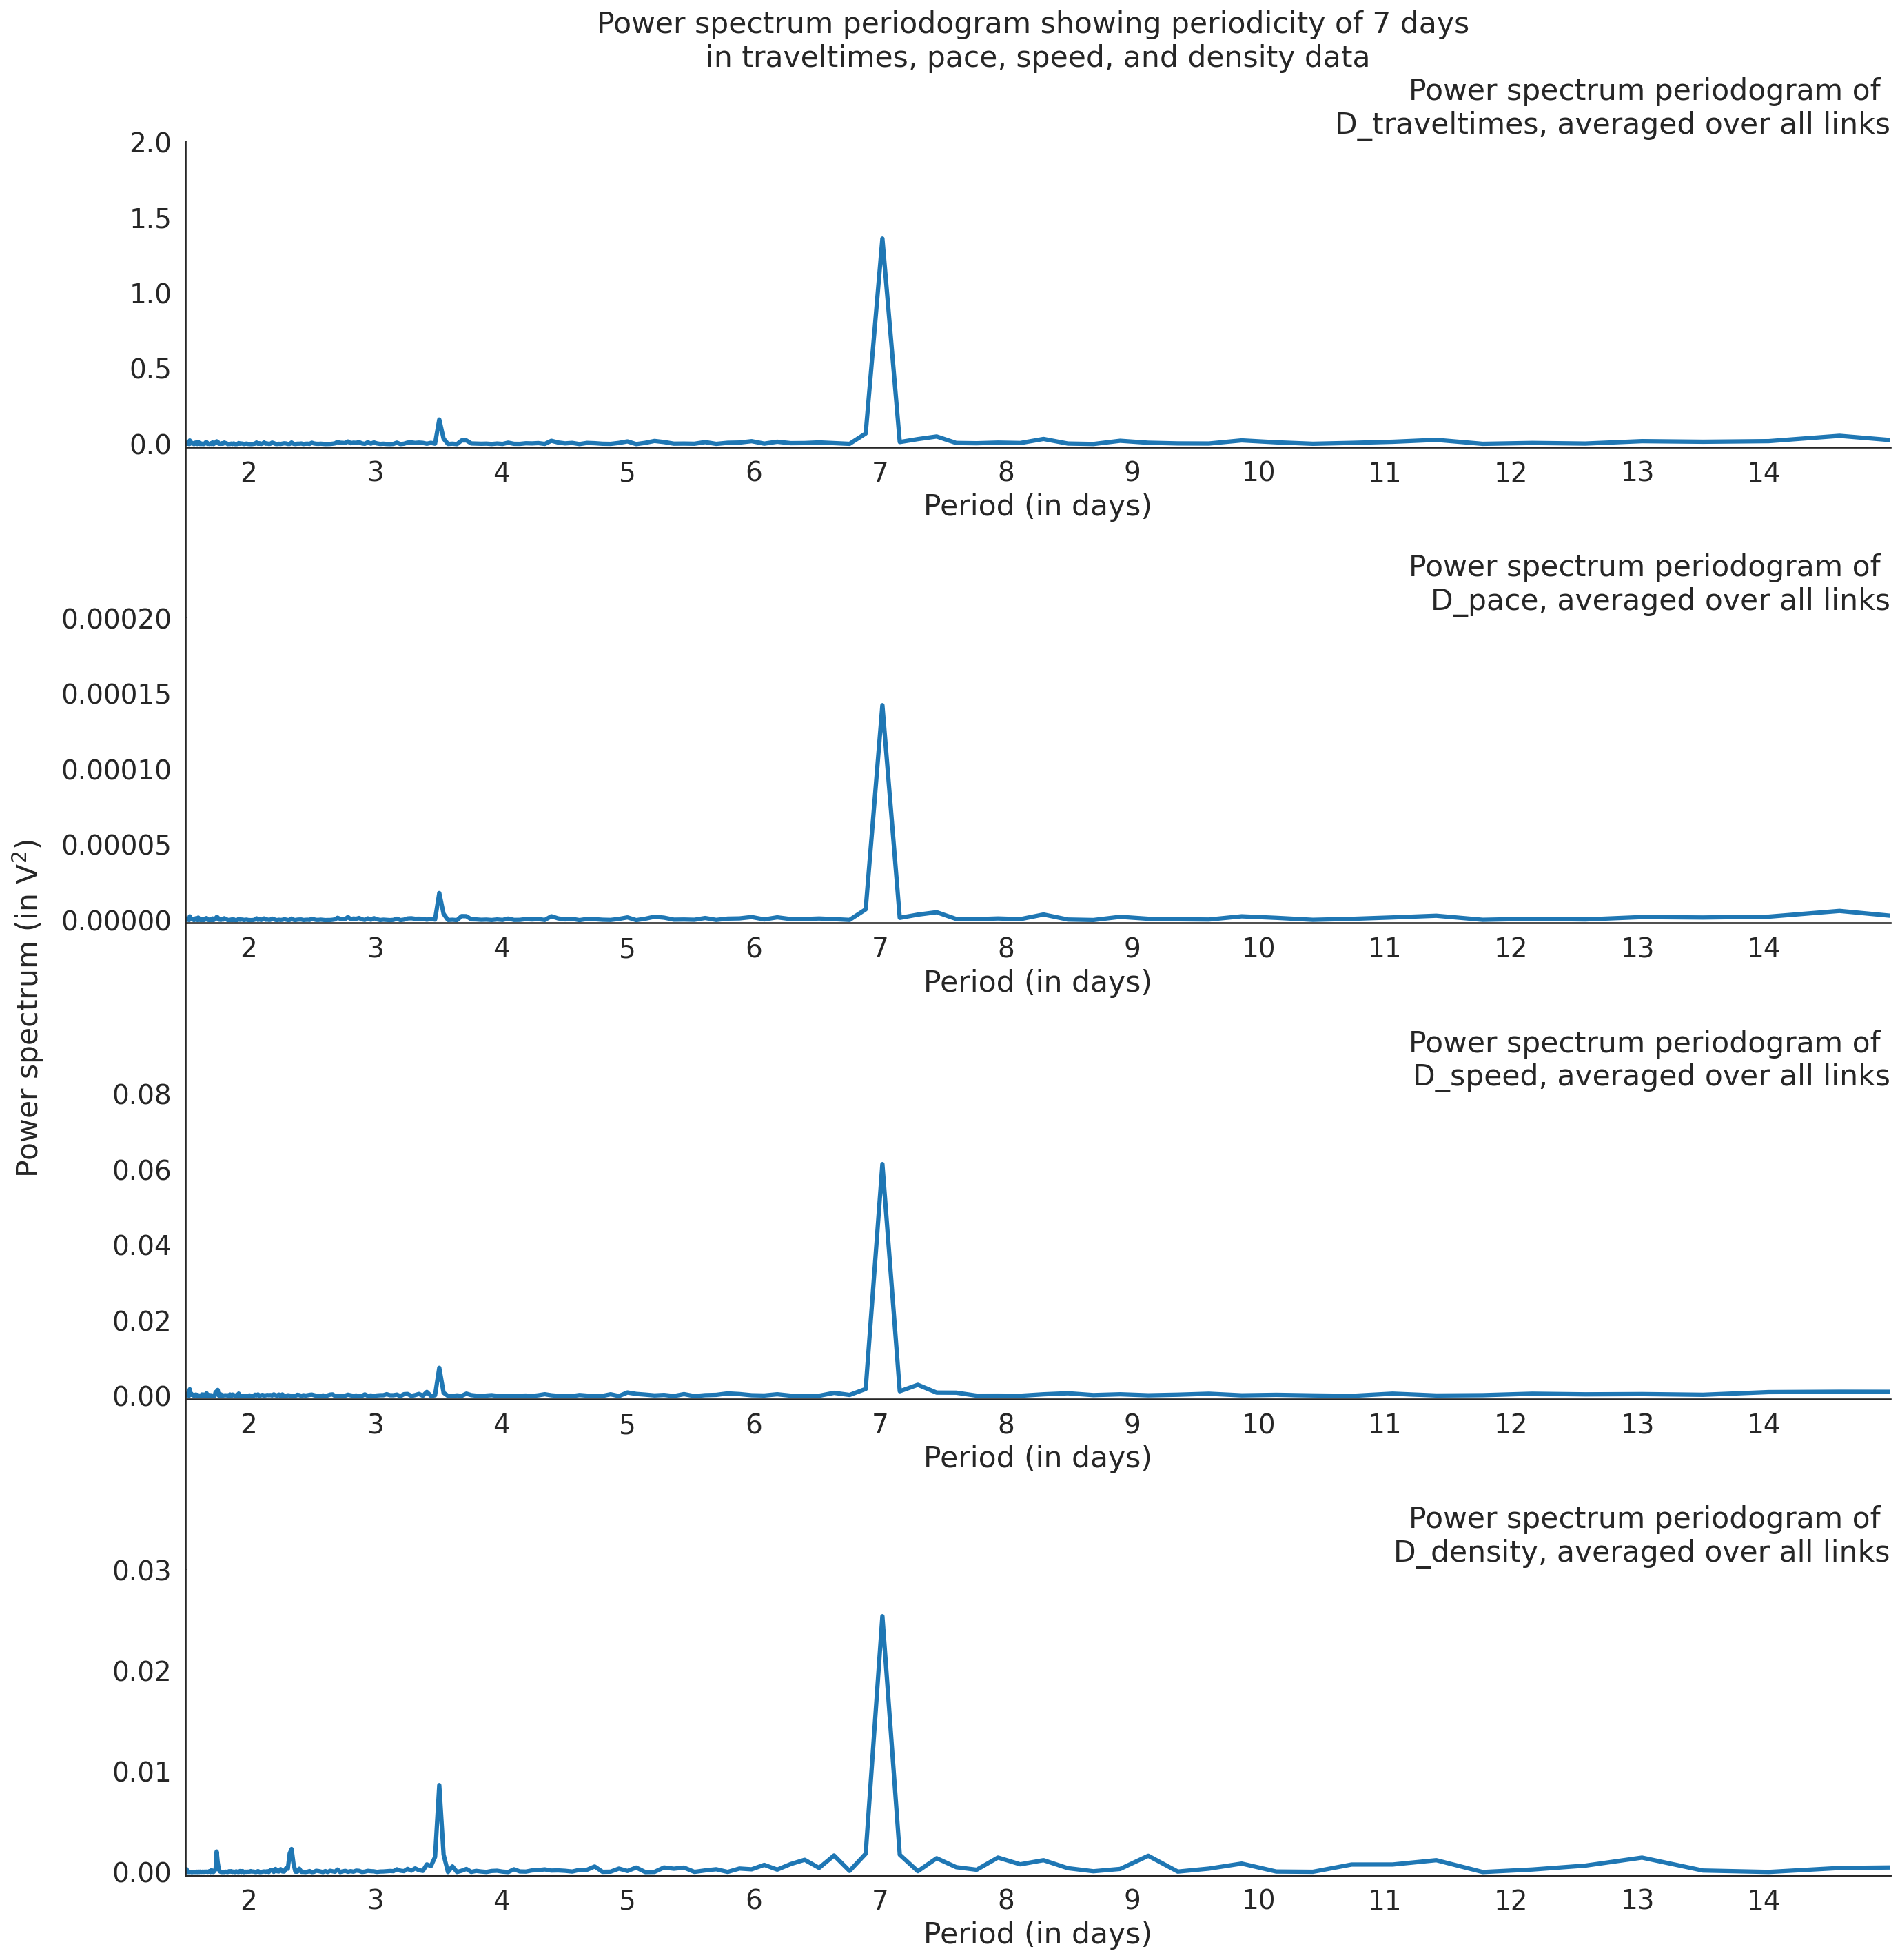

In [33]:
fig = plt.figure(figsize = (20,20), dpi=150)
sns.set_context("notebook", font_scale=1.7, rc={"lines.linewidth": 3})

fig.tight_layout()
plt.ylabel('Power spectrum (in V$^2$)\n\n\n\n')
plt.xticks([])
plt.yticks([])
plt.title('Power spectrum periodogram showing periodicity of 7 days \n'
          'in traveltimes, pace, speed, and density data\n\n')

data = [#(D_trips, 'D_trips', 3e2),
        (D_traveltimes, 'D_traveltimes', 2),
        (D_pace, 'D_pace', 2e-4),
        (D_speed, 'D_speed', 0.08),
        (D_density, 'D_density', 0.03)]

for index, entry in enumerate(data):
    D, name, ymax = entry
    # equivalent but more general
    ax = fig.add_subplot(4, 1, index+1)

    # Setting up the figure
    sns.set_style("white")
    
    D = np.nan_to_num(D)
    vector = np.nanmean(D, axis=1)
    f, Pxx = periodogram(vector, 24, scaling='spectrum')  # Need to sample only in 24 hr windows.
    x = 1/f[16:366]
    y = Pxx[16:366]
    ax.plot(x, y, '-')
    ax.set(xlim = (1.5, 15))
    ax.set_xticks(range(2, 15, 1))
    ax.set(ylim = (-ymax/100, ymax))
    ax.set(xlabel = 'Period (in days)')
    #ax.set(ylabel = '-'*60)
    ax.set_title(f'Power spectrum periodogram of \n{name}, averaged over all links', loc='right')
    #plt.legend()
    plt.tight_layout()
    sns.despine()
    
plt.savefig('../MultiplicativeAlgorithm/Images/Periodogram')

In [ ]:
plot_periodogram(D_trips, 'D_trips', ymax=3e2)